In [1]:
import time
import json
import multiprocessing as mp
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import elasticsearch
from elasticsearch import helpers

import secrets

In [2]:
class AverageOwd():
    def __init__(self,src_host, dest_host,average_delay_mean):
        self.src_host = src_host
        self.dest_host = dest_host
        self.average_delay_mean = average_delay_mean
        
    def __str__(self):
        return "{} -> {} (average delay mean: {})".format(self.src_host, self.dest_host, self.average_delay_mean)
    

In [3]:
def connectDB(user,password):
    '''connect to ElasticSearch db'''
    try:
        es = elasticsearch.Elasticsearch(['atlas-kibana.mwt2.org:9200'], http_auth=(
            user, password), timeout=60, scheme= 'ssl')
        print("Connected", es.info())
        return es

    except Exception as ex:
        print("Error:", ex)

es = connectDB(secrets.user, secrets.password)

Connected {'cluster_uuid': 'HvlJZuzTRReL9Gq1KVSIHQ', 'tagline': 'You Know, for Search', 'cluster_name': 'atlas', 'version': {'minimum_index_compatibility_version': '6.0.0-beta1', 'build_hash': '1c1faf1', 'build_type': 'rpm', 'number': '7.3.2', 'build_snapshot': False, 'build_flavor': 'default', 'build_date': '2019-09-06T14:40:30.409026Z', 'lucene_version': '8.1.0', 'minimum_wire_compatibility_version': '6.8.0'}, 'name': 'uct2-c409'}


In [70]:
# utilify functions

def cacheDict(filePath, dictionary):
    '''utility function to cache data as dictionary '''
    from pathlib import Path
    path = Path(filePath)
    path.write_text( json.dumps(dictionary) )

def plotHeatMap(df,vmin=None,vmax=None,title=None):    
    ax = sns.heatmap(df,vmin=vmin, vmax=vmax)
    ax.set_title(title)

In [8]:
def getAvgDelayMean(from_date,to_date):
    '''Get average delay_mean for each unique source-destination pair within the given time range.'''
    get_avg_delay_mean_query = {
                "size":0,
                "query":{
                    "bool":{
                        "must":[
                            {
                                "range":{
                                    "timestamp":{
                                        "gte":from_date,
                                        "lte":to_date,
                                        "format":"yyyy/MM/dd||epoch_millis"
                                    }
                                }
                            },
                            {
                                "term":{
                                    "dest_production":{
                                        "value":"true"
                                    }
                                }
                            },
                            {
                                "term":{
                                    "src_production":{
                                        "value":"true"
                                    }
                                }
                            }
                        ]
                    }
                },
                "aggs":{
                    "sources":{
                        "terms":{
                            "field":"src_host",
                            "size":9999
                        },
                        "aggs":{
                            "destinations":{
                                "terms":{
                                    "field":"dest_host",
                                    "size":9999
                                },
                                "aggs":{
                                    "average_delay_mean":{
                                        "avg":{
                                            "field":"delay_mean"
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }
    
    results = es.search('ps_owd', body=get_avg_delay_mean_query)
    return results

In [9]:
results = getAvgDelayMean("2019/10/05","2019/11/05")

In [10]:
timestr = time.strftime("%Y%m%d-%H%M%S")
cacheDict('./cached_owd_data'+ timestr +'.json', results)
print('Successfully cached owd data.')

Successfully cached owd data.


In [11]:
def createInstancesFromData(results):
    '''
    Create average_owd class instance from results returned from ElasticSearch.
    '''
    instances = []
    for info_dct in results["aggregations"]["sources"]["buckets"]:
        src_host = info_dct["key"]
        destinations = info_dct["destinations"]["buckets"]
        for dest in destinations:
            dest_host = dest["key"]
            avg_delay_mean = dest["average_delay_mean"]["value"]
            instance = AverageOwd(
                src_host = src_host,
                dest_host = dest_host,
                average_delay_mean = avg_delay_mean 
            )
            instances.append(instance)
    return instances

avg_owd_instances = createInstancesFromData(results)
print("Take a look at one example owd record ...")
print(avg_owd_instances[0])
print("\nGet back {} owd results.".format(len(avg_owd_instances)))

Take a look at one example owd record ...
ccperfsonar2.in2p3.fr -> ps-latency.hepnetcanada.ca (average delay mean: 70.7946451280402)

Get back 4185 owd results.


In [12]:
def formatOwdToDF(avg_owd_instances):
    '''
    Format class data into a nd-array for seaborn visualization.
    '''
    sources = [instance.src_host for instance in avg_owd_instances]
    destinations = [instance.dest_host for instance in avg_owd_instances]
    avg_delays = [instance.average_delay_mean for instance in avg_owd_instances]
    return pd.DataFrame({'source_host':sources, 'dest_host': destinations, 'average_owd':avg_delays})

df = formatOwdToDF(avg_owd_instances)
df.head(20)

,average_owd,dest_host,source_host
0,70.794645,ps-latency.hepnetcanada.ca,ccperfsonar2.in2p3.fr
1,28.307951,lhcperfmon.bnl.gov,ccperfsonar2.in2p3.fr
2,0.740766,perfsonar-ow.cnaf.infn.it,ccperfsonar2.in2p3.fr
3,-4.281509,lapp-ps02.in2p3.fr,ccperfsonar2.in2p3.fr
4,18.802803,perfsonar01.datagrid.cea.fr,ccperfsonar2.in2p3.fr
5,3.299343,llrpsonar1.in2p3.fr,ccperfsonar2.in2p3.fr
6,-1.536320,lpnhe-psl.in2p3.fr,ccperfsonar2.in2p3.fr
7,10.533490,perfsonar2.na.infn.it,ccperfsonar2.in2p3.fr
8,4.289391,marperf02.in2p3.fr,ccperfsonar2.in2p3.fr
9,37.851231,tech-ps.hep.technion.ac.il,ccperfsonar2.in2p3.fr


In [29]:
from datetime import datetime

# Get a list of owd_mean values for specified src-dest pair
    
def extractOwdMeanInfofromRes(data):
    '''extract owd_mean from res get back from db'''
    owd_mean = data['aggregations']['average_delay_mean']['value']
#     print('owd_mean:',owd_mean)
    return owd_mean


# def getSingleOwd(src_host=None,dest_host=None,from_date=None,to_date=None, interval=5):    
#     date_list = list(getStartEnd(from_date,to_date, interval))
#     owd_list = []
#     for i in range(interval):
#         owd = getSingleOwd(src_host,dest_host,from_date=date_list[i],to_date=date_list[i+1])
#         owd_mean = extractOwdInfofromRes(owd)   
#         owd_list.append(owd_mean)
#     return owd_list
    
    
def getStartEnd(from_date,to_date,interval=5):
    '''
    get a list of intervals as formatted datetime based on `from_date` and `to_date`;
    interval decided how many chuncks of time range you would like to get
    '''
    begin = datetime.strptime(from_date,"%Y/%m/%d")
    end = datetime.strptime(to_date,"%Y/%m/%d")

    delta = (end-begin) / interval
    for i in range(interval):
        yield (begin + delta * i).strftime("%Y/%m/%d")
    yield end.strftime("%Y/%m/%d")


In [30]:
# TODO: get each unique pair of source-destination, and query db again to get the data across multiple timestamps
# TODO: reindex owd for those above-zero values

def getSingleOwd(src_host, dest_host,from_date, to_date):
    '''Get owd for single pair of src-dest for specific time range'''
    query = {
                "size":0,
                "query":{
                    "bool":{
                        "must":[
                            {
                                "range":{
                                    "timestamp":{
                                        "gte":from_date,
                                        "lte":to_date,
                                        "format":"yyyy/MM/dd||epoch_millis"
                                    }
                                }
                            },
                            {
                                "term":{
                                    "src_host":{
                                        "value":src_host
                                    }
                                }
                            },
                            {
                                "term":{
                                    "dest_host":{
                                        "value":dest_host
                                    }
                                }
                            }
                        ]
                    }
                },
               
                "aggs":{
                    "average_delay_mean":{
                        "avg":{
                            "field":"delay_mean"
                        }
                    }
                }
                            
            }
                    
    results = es.search('ps_owd', body= query)
    return results


pair_dct = set() # init a set to store all unique pair of src-dest
drifted_routes = []

for index, row in df.iterrows():
    pair = (row['source_host'], row['dest_host'])
    pair_dct.add(pair)  # get all possible unique pair of src-dest
    
    owd_res = getSingleOwd(row['source_host'], row['dest_host'], from_date="2019/10/05", to_date="2019/11/05")     
    owd_mean = extractOwdMeanInfofromRes(owd_res)
    if owd_mean < 0:
        drifted_routes.append(pair)


In [72]:
print('There are %d unique routes that are drifted.'%len(drifted_routes))

timestr = time.strftime("%Y%m%d-%H%M%S")
cacheDict('./cached_drifted_routes_'+ timestr +'.json', drifted_routes)
print('Successfully cached drifted routes.')

There are 261 unique routes that are drifted.


TypeError:                                source_host                         dest_host  \
3                    ccperfsonar2.in2p3.fr                lapp-ps02.in2p3.fr   
6                    ccperfsonar2.in2p3.fr                lpnhe-psl.in2p3.fr   
10                   ccperfsonar2.in2p3.fr            clrperf-owamp.in2p3.fr   
11                   ccperfsonar2.in2p3.fr              psonar1.lal.in2p3.fr   
40                   ccperfsonar2.in2p3.fr                  ps1.ochep.ou.edu   
51                   ccperfsonar2.in2p3.fr        perfsonar-de-kit.gridka.de   
74                   ccperfsonar2.in2p3.fr                 psl01-gva.cern.ch   
93             perfsonar01.datagrid.cea.fr                lpnhe-psl.in2p3.fr   
94             perfsonar01.datagrid.cea.fr                marperf02.in2p3.fr   
95             perfsonar01.datagrid.cea.fr             ccperfsonar2.in2p3.fr   
96             perfsonar01.datagrid.cea.fr                lapp-ps02.in2p3.fr   
97             perfsonar01.datagrid.cea.fr               llrpsonar1.in2p3.fr   
98             perfsonar01.datagrid.cea.fr            clrperf-owamp.in2p3.fr   
99             perfsonar01.datagrid.cea.fr              psonar1.lal.in2p3.fr   
100            perfsonar01.datagrid.cea.fr          lpsc-perfsonar2.in2p3.fr   
101            perfsonar01.datagrid.cea.fr               nanperfs01.in2p3.fr   
102            perfsonar01.datagrid.cea.fr               sbgperfps1.in2p3.fr   
103            perfsonar01.datagrid.cea.fr                   psbud01.kfki.hu   
125            perfsonar01.datagrid.cea.fr                  ps1.ochep.ou.edu   
128            perfsonar01.datagrid.cea.fr             perfsonar-ps.ndgf.org   
134            perfsonar01.datagrid.cea.fr  perfsonar-latency.esc.qmul.ac.uk   
135            perfsonar01.datagrid.cea.fr           perfsonar01.lcg.cscs.ch   
136            perfsonar01.datagrid.cea.fr            hepsonar2.ph.liv.ac.uk   
138            perfsonar01.datagrid.cea.fr                 psonar.cis.gov.pl   
139            perfsonar01.datagrid.cea.fr        perfmon.dur.scotgrid.ac.uk   
140            perfsonar01.datagrid.cea.fr       gridpp-ps-lat.ecdf.ed.ac.uk   
143            perfsonar01.datagrid.cea.fr     t2ps-latency.physics.ox.ac.uk   
144            perfsonar01.datagrid.cea.fr           lcgps01.gridpp.rl.ac.uk   
146            perfsonar01.datagrid.cea.fr         perfsonar-ow.cnaf.infn.it   
147            perfsonar01.datagrid.cea.fr             heplnx129.pp.rl.ac.uk   
...                                    ...                               ...   
3410                   ps1.kipt.kharkov.ua              psonar1.lal.in2p3.fr   
3441                       ps.truba.gov.tr              psonar1.lal.in2p3.fr   
3472                        pship01.csc.fi              psonar1.lal.in2p3.fr   
3500                 repos.indiacms.res.in              psonar1.lal.in2p3.fr   
3532              psfrascati02.lnf.infn.it              psonar1.lal.in2p3.fr   
3566             perfsonar01.cmsaf.mit.edu              psonar1.lal.in2p3.fr   
3570             perfsonar01.cmsaf.mit.edu                 perflat.ciemat.es   
3591           perfsonar2-de-kit.gridka.de                  ps1.ochep.ou.edu   
3678                   nanperfs01.in2p3.fr              psonar1.lal.in2p3.fr   
3725              lpsc-perfsonar2.in2p3.fr              psonar1.lal.in2p3.fr   
3754                     sonar2.itim-cj.ro                  ps1.ochep.ou.edu   
3817                       117.103.105.191              psonar2.lal.in2p3.fr   
3831                lhc-latency.twgrid.org                  ps1.ochep.ou.edu   
3877                   sbgperfps1.in2p3.fr              psonar1.lal.in2p3.fr   
3956  mwt2-ps03.campuscluster.illinois.edu        osg.chic.nrp.internet2.edu   
3985                     perfsonar.unl.edu        osg.kans.nrp.internet2.edu   
3992                      psonar3.fnal.gov        osg.chic.nrp.internet2.edu   
4007      grid-perf1.physik.rwth-aachen.de                 perflat.ciemat.es   
4009      grid-perf1.physik.rwth-aachen.de              psonar1.lal.in2p3.fr   
4041                    atrogr007.nipne.ro                  ps1.ochep.ou.edu   
4084                perfsonar1.hep.kbfi.ee                 perflat.ciemat.es   
4085                perfsonar1.hep.kbfi.ee              psonar1.lal.in2p3.fr   
4120                       144.206.131.133              btw-lat.grid.kiae.ru   
4123                       144.206.131.133                    psum01.itep.ru   
4124                       144.206.131.133           btw-lat.t1.grid.kiae.ru   
4146                2001:67c:1bdc:100::133                    psum01.itep.ru   
4155                        159.93.229.150                  t2-pfsn1.jinr.ru   
4156               2a05:81c5:301:228::e596                  t2-pfsn1.jinr.ru   
4183                          129.93.5.165                      163.253.71.2   
4184                 perfsonar01.ft.uam.es     perfsonar02-iep-grid.saske.sk   

      negative_average_owd  
3            -4.281509e+00  
6            -1.536320e+00  
10           -2.940317e+00  
11           -1.377172e+03  
40           -5.201156e+02  
51           -6.177502e-01  
74           -4.538438e+00  
93           -1.726088e+01  
94           -5.277658e+00  
95           -8.420669e+00  
96           -1.352645e+01  
97           -1.099454e+01  
98           -1.476774e+01  
99           -1.335456e+03  
100          -2.675473e+00  
101          -1.135017e+01  
102          -1.086201e+01  
103          -7.483883e+00  
125          -5.110049e+02  
128          -2.793688e+00  
134          -1.265055e+01  
135          -1.124819e+01  
136          -8.725611e+00  
138          -3.066856e+00  
139          -9.434101e+00  
140          -6.581701e+00  
143          -1.137372e+01  
144          -1.267499e+01  
146          -8.526868e+00  
147          -1.289606e+01  
...                    ...  
3410         -1.297684e+03  
3441         -1.351810e+03  
3472         -1.364700e+03  
3500         -1.266999e+03  
3532         -1.482546e+03  
3566         -1.537884e+03  
3570         -7.270527e+01  
3591         -5.198552e+02  
3678         -1.341255e+03  
3725         -1.498447e+03  
3754         -8.838527e+02  
3817         -1.333131e+03  
3831         -4.220440e+02  
3877         -2.195747e+03  
3956         -1.065670e+00  
3985         -3.180775e+00  
3992         -1.526040e+00  
4007         -8.985641e+01  
4009         -1.385184e+03  
4041         -7.403750e+02  
4084         -7.924771e+01  
4085         -1.597763e+03  
4120         -3.096109e+00  
4123         -5.588014e-01  
4124         -1.495769e+00  
4146         -5.159603e-01  
4155         -7.443095e-02  
4156         -7.080900e-02  
4183         -4.675560e+00  
4184         -1.853432e+12  

[261 rows x 3 columns] is not JSON serializable

In [66]:
# Get a list of drifted routes (with negative owd)

import multiprocessing as mp
from multiprocessing import Pool, TimeoutError

num_partitions = 10 #number of partitions to split dataframe
# num_cores = 4 #number of cores on your machine
num_cores = mp.cpu_count() - 1

def parallelDf(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(getDriftedRoutes, df_split))
    pool.close()
    pool.join()
    return df

def getDriftedRoutes(df):
#     data['length_of_word'] = data['species'].apply(lambda x: len(x))
    df['negative_average_owd'] = df[df['average_owd'] < 0]['average_owd']
    return df

data = df.copy()
temp = parallelDf(data, getDriftedRoutes)
drifted_routes = temp[['source_host','dest_host','negative_average_owd']].dropna()

In [81]:
drifted_routes
drifted_routes.to_csv('./drifted_routes.csv',index=False)

In [101]:
drifted_routes[drifted_routes['source_host']=='perfsonar01.datagrid.cea.fr']

,source_host,dest_host,negative_average_owd
93,perfsonar01.datagrid.cea.fr,lpnhe-psl.in2p3.fr,-17.260876
94,perfsonar01.datagrid.cea.fr,marperf02.in2p3.fr,-5.277658
95,perfsonar01.datagrid.cea.fr,ccperfsonar2.in2p3.fr,-8.420669
96,perfsonar01.datagrid.cea.fr,lapp-ps02.in2p3.fr,-13.526451
97,perfsonar01.datagrid.cea.fr,llrpsonar1.in2p3.fr,-10.994544
98,perfsonar01.datagrid.cea.fr,clrperf-owamp.in2p3.fr,-14.767744
99,perfsonar01.datagrid.cea.fr,psonar1.lal.in2p3.fr,-1335.455765
100,perfsonar01.datagrid.cea.fr,lpsc-perfsonar2.in2p3.fr,-2.675473
101,perfsonar01.datagrid.cea.fr,nanperfs01.in2p3.fr,-11.350167
102,perfsonar01.datagrid.cea.fr,sbgperfps1.in2p3.fr,-10.862015


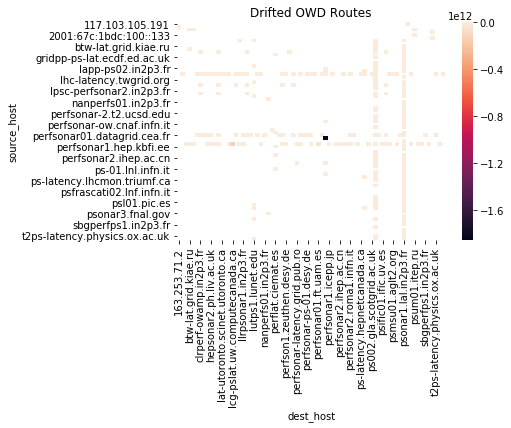

In [71]:
# plot heatmap for drifted routes
pivot_drifted_routes = drifted_routes.pivot('source_host','dest_host', 'negative_average_owd')
plotHeatMap(pivot_drifted_routes,title='Drifted OWD Routes')

In [88]:
# TODO: take a look at several drifted routes, and plot the owd data trend    

def checkOwdTrend(src_host, dest_host, from_date, to_date, interval=30):
    dates = [date for date in getStartEnd(from_date=from_date,to_date=to_date,interval=interval)]
    
    owd_mean_list = []
    from_dates, to_dates = [],[]
    
    for i in range(len(dates)-1):
        owd_res = getSingleOwd(src_host, dest_host, from_date=dates[i], to_date=dates[i+1])     
        owd_mean = extractOwdMeanInfofromRes(owd_res)
        owd_mean_list.append(owd_mean)
        from_dates.append(dates[i])
        to_dates.append(dates[i+1])
    
    return pd.DataFrame({'start_date':from_dates, 'end_date':to_dates, 'owd_mean':owd_mean_list}, 
                        columns=['start_date', 'end_date', 'owd_mean'])

    
fr_jp = checkOwdTrend(src_host='perfsonar01.datagrid.cea.fr',
             dest_host='perfsonar1.icepp.jp',
             from_date='2019/10/05',
             to_date='2019/11/05')   

In [89]:
fr_jp.head()

,start_date,end_date,owd_mean
0,2019/10/05,2019/10/06,83.182202
1,2019/10/06,2019/10/07,84.077854
2,2019/10/07,2019/10/08,86.092931
3,2019/10/08,2019/10/09,85.571183
4,2019/10/09,2019/10/10,83.798132


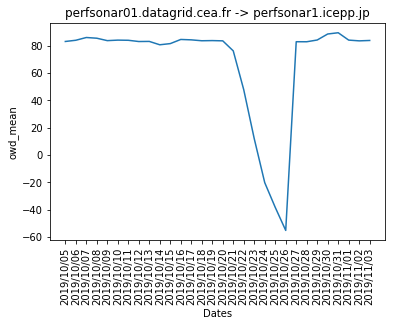

In [99]:
def plotOwdTrend(src_host=None,dest_host=None,from_date=None,to_date=None,interval=30):
    '''
    Plot Owd_mean trend with src-dest pair specified; 
    default time intervals between `from_date` and `to_date` is 30.
    '''
    src_dest_owd = checkOwdTrend(src_host,dest_host,from_date,to_date,interval)
    
    ax = sns.lineplot(x=src_dest_owd['start_date'], y=src_dest_owd['owd_mean'])
    ax.set_xticklabels(labels =src_dest_owd['start_date'], rotation=90)
    plt.xlabel("Dates")
    ax.set_title('{} -> {}'.format(src_host, dest_host))
    plt.show()
    
plotOwdTrend(src_host='perfsonar01.datagrid.cea.fr',
             dest_host='perfsonar1.icepp.jp',
             from_date='2019/10/05',
             to_date='2019/11/05')

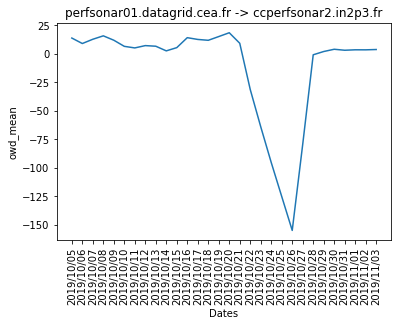

In [103]:
plotOwdTrend(src_host='perfsonar01.datagrid.cea.fr',
             dest_host='ccperfsonar2.in2p3.fr',
             from_date='2019/10/05',
             to_date='2019/11/05')

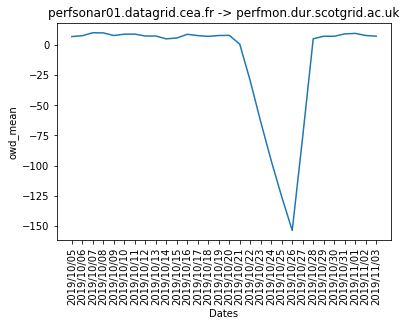

In [104]:
plotOwdTrend(src_host='perfsonar01.datagrid.cea.fr',
             dest_host='perfmon.dur.scotgrid.ac.uk',
             from_date='2019/10/05',
             to_date='2019/11/05')

## Heatmap for general cases

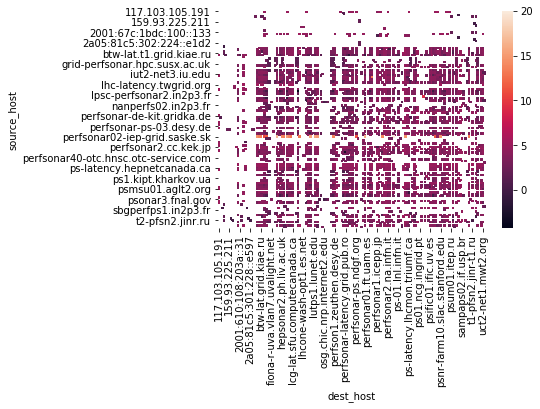

In [130]:
# handle log-transformed heatmap
df['log(average_owd+1)'] = df['average_owd'].apply(lambda x: np.log1p(x)) # negative values will be turned into Nan when using log1p

pivot_df_log = df.pivot('source_host','dest_host', 'log(average_owd+1)')
min_log_avg_delay, max_log_avg_delay = min(df['log(average_owd+1)']), max(df['log(average_owd+1)'])
plotHeatMap(pivot_df_log, min_log_avg_delay, max_log_avg_delay)


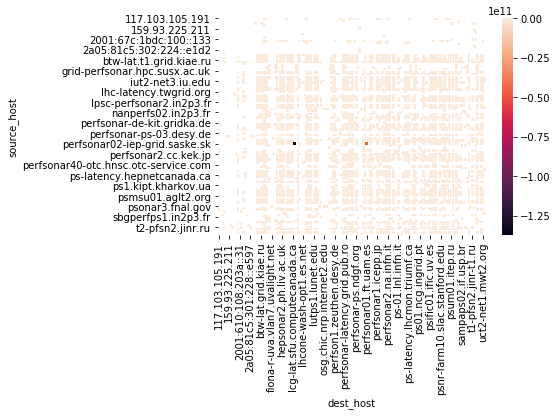

In [27]:
pivot_df = df.pivot('source_host','dest_host','average_owd')
min_avg_delay, max_avg_delay = min(df['average_owd']), max(df['average_owd']) # used as upper and lower bound
plotHeatMap(pivot_df,min_avg_delay,max_avg_delay)

max owd: 500602974.8164016
min owd: 0.0653283154412879


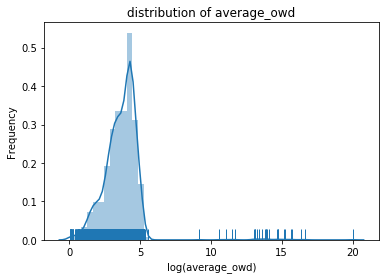

In [120]:
def plotDist(arr, xlabel=None, y_label="Frequency", title=None):
    '''Plot log-transformed distribution of average owd data.'''
    ax = sns.distplot(np.log1p(arr), rug=True)  # log1p (more accurate for vals close to zero)
    ax.set(xlabel=xlabel,ylabel=y_label, title=title)
    plt.show()

def plotBar(x=None,y=None,data=None,color=None,title=None,xlabel=None,ylabel=None):
    ax = sns.barplot(x=x, y=y, data=data, color=color)
    ax.set(xscale="log",title=title, xlabel=xlabel, ylabel=ylabel)
#     ax.set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

average_owd = df['average_owd'].to_list()
average_owd_above_zero = [val for val in average_owd if val >= 0] # only picked owd above zero

print("max owd: {}".format(max(average_owd_above_zero)))
print("min owd: {}".format(min(average_owd_above_zero)))

plotDist(average_owd_above_zero, xlabel='log(average_owd)', title='distribution of average_owd')

There are 1297 bins.


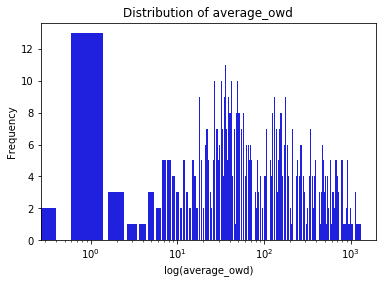

In [117]:
def plotOwdBarChart():
    '''
    Create customized bins with distance = 0.1. 
    Vals within distance = 0.1 will be grouped into the same bin
    Notice that bin widths are different in this case.
    '''
    
    # plot bar chart: xaxis -> average_owd, yaxis -> frequency
    import collections
    bins = collections.defaultdict(list)

    binId = lambda x: int(x*10)  
    for val in average_owd_above_zero:
        bins[binId(val)].append(val)

    print("There are {} bins.".format(len(bins)))

    count_dct = {}
    for vals in bins.values():
        # use median value to represent the values of each bin
        count_dct[np.median(vals)] = len(vals)  
        # `count_dct` looks like: {"median of bin1": size of bin1,...}

    plotBar(x=list(count_dct.keys()),y=list(count_dct.values()), color = 'blue', \
            xlabel='log(average_owd)', ylabel='Frequency',title='Distribution of average_owd')

plotOwdBarChart()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log1p
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'log(average_owd)')

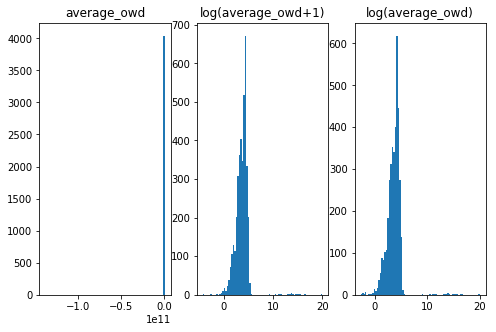

In [107]:
# plot histgram of average_owd (including negative values)

fig, subaxes = plt.subplots(1, 3, figsize=(8, 5))
subaxes[0].hist(df['average_owd'],bins=80)
subaxes[0].set_title("average_owd")

subaxes[1].hist(np.log1p(df['average_owd']),bins=80)
subaxes[1].set_title("log(average_owd+1)")

subaxes[2].hist(np.log(df['average_owd']),bins=80)
subaxes[2].set_title("log(average_owd)")

why use log1p instead of log: 
In short, if the dataset is all greater than 1, then log is usually fine. But, if the dataset has numbers between 0 and 1, then log1p is usually better. - [reference](https://scicomp.stackexchange.com/questions/20629/when-should-log1p-and-expm1-be-used) Basically, log1p can get a better precision for small numbers.

In [ ]:
# When to use log-transformed distribution:
# log-transformed is often used to reduce skew
# distribution => log-transformed can be used in regression modeling 
# scatter plot => can identify the relationships between two variables more easily

# log-transformed distribution可以用于观察普遍趋势(relative changes), 但无法得知absolute changes

__What we can tell from the diagram__:<br>
Distribution of average_owd is mostly condense, whereas a small amount of average_owd is much larger than the majority. There is also a small portion of average_owd lies below zero. 


In [ ]:
# TODO: networkX mining 
# TODO: explore relationship between delay_sd, delay_mean, delay_median

In [ ]:
# Questions: (Nov.3rd)
# - should I separate those above-zero values vs. below-zero values (e.g., create new index in db?)
# - try to plot several src-dest pair => but how to choose which pairs to plot?  --> e.g., focus on those with higher sd?